## Question 8

In [130]:
import numpy as np
import matplotlib.pyplot as plt

In [5]:
# Normal random variable generator
def NormalGenerator(mean, scale):
    while True:
        u1 = np.random.random()
        u2 = np.random.random()
        tmp1 = np.sqrt(-2*np.log(u1))
        tmp2 = 2*np.pi*u2
        yield tmp1*np.cos(tmp2)*scale + mean
        yield tmp1*np.sin(tmp2)*scale + mean

In [6]:
# importance sampling: Calculate E(h(X)) under f(.) measure by E(h(X)w(X)) under q(.) measure

def PI_hat_2(h, w , RNG, sampleSize, nrepeats = None):
    ''' h(x) is the function whose expectation is to be calculated
        w(x) is the Ragon-Nikedym Derivative f(.)/q(.) or its multipilication 
        RNG is the random number generator for q(.)
    '''
    def SingleTrial(h, w , RNG, sampleSize):
        RandomNumbers = np.array([next(RNG) for i in range(sampleSize)])
        tmp = w(RandomNumbers)
        return np.sum(h(RandomNumbers) * tmp)/np.sum(tmp)
    if nrepeats == None:
        return SingleTrial(h, w , RNG, sampleSize)
    else:
        resultArray = np.array([SingleTrial(h, w , RNG, sampleSize) for i in range(nrepeats)])
        return resultArray

In [64]:
# Load the arguments
m = 10000
h = lambda x: x**5/(1+(x-3)**2)
w1 = lambda x: np.exp(-x**2/8+x**2/2)
w2 = lambda x: x-x+1  # Implementation Note: We use x-x+1 is to make sure the result is still an array with the same shape with x
w3 = lambda x : np.exp(-x**2/8+x**2/18)
N01 = NormalGenerator(0,1)
N04 = NormalGenerator(0,2)
N09 = NormalGenerator(0,3)

In [65]:
# using q1(x)
PI_hat_2(h,w1,N01,m)

19.750497849659528

In [66]:
# using q2(x)
PI_hat_2(h,w2,N04,m)

36.87755481844184

In [67]:
# using q3(x)
PI_hat_2(h,w3,N09,m)

36.60767208415858

In [72]:
# Repeated Sampling

# N(0,1)
ResultList = PI_hat_2(h,w1,N01,m, nrepeats = 100)
print('Sample Mean is ' +  str(ResultList.mean()))
print('Sample Variance is ' +  str(ResultList.var()))

Sample Mean is 31.77333092053756
Sample Variance is 205.249498989962


In [70]:
# N(0,4)
ResultList = PI_hat_2(h,w2,N04,m, nrepeats = 100)
print('Sample Mean is ' +  str(ResultList.mean()))
print('Sample Variance is ' +  str(ResultList.var()))

Sample Mean is 36.99934752374407
Sample Variance is 1.645307424703538


In [73]:
# N(0,9)
ResultList = PI_hat_2(h,w3,N09,m, nrepeats = 100)
print('Sample Mean is ' +  str(ResultList.mean()))
print('Sample Variance is ' +  str(ResultList.var()))

Sample Mean is 37.17974769785113
Sample Variance is 0.6992282504273193


## Question 9

### a)

In [77]:
# Use the generator we defined in Question 8
N01 = NormalGenerator(0,1)
NormalRandomNumbers = np.array([next(N01) for i in range(1000000)])
(NormalRandomNumbers>4).sum()

22

1 million samples lead to only 22 numbers, the probability is too small to accurately estimate it directly. We thereby use a trial distribution as TwoSidedExponential(4) to use importance sampling method. ( To make it a heavier tail) 

In [151]:
def ExponentialGenerator(beta):
    while True:
        u1 = np.random.random()
        yield -beta*np.log(u1)
def TwoSidedExponentialGenerator(beta):
    while True:
        u1 = np.random.random()
        AbsResult = -beta*np.log(u1)
        u2 = np.random.random()
        if u2<0.5:
            yield AbsResult
        else:
            yield -AbsResult

In [163]:
# Using PI_2 Estimator

beta = 4
h1 = np.vectorize(lambda x: 1 if x> 4 else 0)
w = lambda x: np.exp(abs(x)/beta-x**2/2)
my_estimate_for_p_larger_than_4 = PI_hat_2(h1, w, TwoSidedExponentialGenerator(beta), 1000000)
print(my_estimate_for_p_larger_than_4)

3.161904683420398e-05


### b) We use trial random variable X where *X-4~ Exponential(1)*

In [124]:
# The trial variable generator
def ExponentialGenerator_plus4():
    while True:
        u1 = np.random.random()
        yield -np.log(u1) + 4

In [166]:
# Rejection method implementation
def TargetSample(TrialGenerator, w, c, size = 1):
    ''' The Size denote the number of of trials to generate the target sample, including the samples that are abandoned'''
    # c should be sightly larger than the max(f(x)/g(x))
    
    # initialize the container
    result = []
    
    # Create a list of target random variable
    for i in range(size):
            
        # Generate instrumental variable
        Instru = next(TrialGenerator)
                
        # Generate uniform r.v.
        Uniform = np.random.random()
            
        # Decide whether to abandon the result
        if Uniform <= w(Instru)/c:
                result.append(Instru)
                
    # Making the return value a np.ndarray
    Array = np.array(result)
    
    return Array

In [167]:
def PI_hat_0(h, w, RNG, sampleSize, c, nrepeats = None):
    ''' h(x) is the function whose expectation is to be calculated
        w(x) is the Ragon-Nikedym Derivative f(.)/q(.) or its multipilication 
        RNG is the random number generator for q(.)
    '''
    def SingleTrial(h, w , RNG, sampleSize):
        RandomNumbers = TargetSample(RNG, w, c, sampleSize)
        return h(RandomNumbers).mean()
    
    if nrepeats == None:
        return SingleTrial(h, w , RNG, sampleSize)
    else:
        resultArray = np.array([SingleTrial(h, w , RNG, sampleSize) for i in range(nrepeats)])
        return resultArray

In [168]:
# Rejection method
h = lambda x : x
w_unnormalized = lambda x: np.exp(-x**2/2+x-4)
# w_unnormalized has maximum when x = 1, however x>4, as a result, the maximum is exp(-8)
c = np.exp(-8)
PI_hat_0(h, w_unnormalized, ExponentialGenerator_plus4(), 10000, c)

4.229746266845291

{'whiskers': [<matplotlib.lines.Line2D at 0x1ecc6f9a400>,
 'caps': [<matplotlib.lines.Line2D at 0x1ecc6f9aa60>,
 'boxes': [<matplotlib.lines.Line2D at 0x1ecc6f81f70>],
 'medians': [<matplotlib.lines.Line2D at 0x1ecc73091c0>],
 'fliers': [<matplotlib.lines.Line2D at 0x1ecc7309550>],
 'means': []}

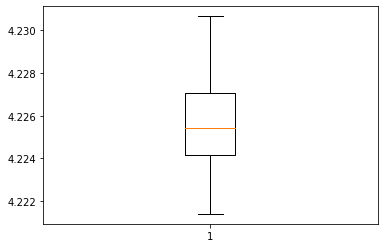

In [131]:
# Repeat 100 times rejection method
Estimates0 = PI_hat_0(h, w_unnormalized, ExponentialGenerator_plus4(), 10000, c, 100)
plt.boxplot(Estimates0)

In [132]:
# Importance sampling method: PI_hat_1
# importance sampling: Calculate E(h(X)) under f(.) measure by E(h(X)w(X)) under q(.) measure

def PI_hat_1(h, w , RNG, sampleSize, nrepeats = None):
    ''' h(x) is the function whose expectation is to be calculated
        w(x) is the Ragon-Nikedym Derivative f(.)/q(.)!!!! NOT its multiplication!!!
        RNG is the random number generator for q(.)
    '''
    def SingleTrial(h, w , RNG, sampleSize):
        RandomNumbers = np.array([next(RNG) for i in range(sampleSize)])
        return np.sum(h(RandomNumbers) * w(RandomNumbers))/RandomNumbers.size
    if nrepeats == None:
        return SingleTrial(h, w , RNG, sampleSize)
    else:
        resultArray = np.array([SingleTrial(h, w , RNG, sampleSize) for i in range(nrepeats)])
        return resultArray

In [164]:
# Importance sampling method: PI_hat_1
# Don't know the exact conditional probability, use my Estimate instead
w_normalized = lambda x: np.exp(-x**2/2+x-4)/(my_estimate_for_p_larger_than_4*np.sqrt(2*np.pi))
PI_hat_1(h, w_normalized, ExponentialGenerator_plus4(), 10000)

4.312189001043268

{'whiskers': [<matplotlib.lines.Line2D at 0x1ecc9fe1100>,
 'caps': [<matplotlib.lines.Line2D at 0x1ecc9fe1820>,
 'boxes': [<matplotlib.lines.Line2D at 0x1ecc780ed30>],
 'medians': [<matplotlib.lines.Line2D at 0x1ecc9fe1f40>],
 'fliers': [<matplotlib.lines.Line2D at 0x1ecc9fd6310>],
 'means': []}

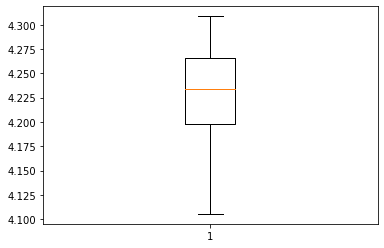

In [165]:
# Repeat 100 times using PI1 estimator
Estimates1 = PI_hat_1(h, w_normalized, ExponentialGenerator_plus4(), 10000, 100)
plt.boxplot(Estimates1)

In [150]:
# PI2 estimator, the implementation is in Question 8 above
PI_hat_2(h, w_unnormalized, ExponentialGenerator_plus4(), 10000)

4.227755698050874

{'whiskers': [<matplotlib.lines.Line2D at 0x1ecca7076d0>,
 'caps': [<matplotlib.lines.Line2D at 0x1ecca707df0>,
 'boxes': [<matplotlib.lines.Line2D at 0x1ecca707340>],
 'medians': [<matplotlib.lines.Line2D at 0x1ecca6fa550>],
 'fliers': [<matplotlib.lines.Line2D at 0x1ecca6fa8e0>],
 'means': []}

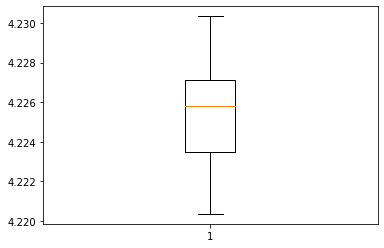

In [139]:
# Repeat 100 times using PI2 estimator
Estimates2 = PI_hat_2(h, w_unnormalized, ExponentialGenerator_plus4(), 10000, 100)
plt.boxplot(Estimates2)

We can see the variance of estimators is clearly smaller in PI0 and PI2 than PI1, indicating PI1 is a bad estimator.<br>
Also, it is faster to use PI2 than PI0.